## Configure environment

In [1]:
import random
import time
import os
import datetime
import itertools
import math
import sys
from random import randint

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [3]:
if IN_COLAB:
  if not os.path.exists("/data/video_prediction_dataset.hdf5"):
    !gdown 1fYtaFcGKSL8ykJFbewAFsFf9C4aW0DuV
    !gdown 1VILdkCRWsDTrN9DPeMLh8jlibAoBLzy-
    !gdown 197pDAI8KVsiDAA1xaPbitZpmvzh9CDqT
    !gdown 1XqgXAtxWUdnBJnvQTtEr8JpBkVi3JuSC
    !gdown 1_DVttDvwxCm_QGDxU2tbaaclWKd1VCau
    %mkdir -p /data
    %mv /content/*.hdf5 /data/
    %mv /content/*.npy /data/


In [4]:
if IN_COLAB:
  COLAB_BASE_DIR = "/content/gdrive/MyDrive/Universidad/VIU/TFM/notebooks/"
  from google.colab import drive
  drive.mount('/content/gdrive/')
  sys.path.append(os.path.join(COLAB_BASE_DIR, 'CNNLSTM'))
  sys.path.append(os.path.join(COLAB_BASE_DIR, 'common'))

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [5]:
%%capture
%pip install torch torchvision h5py xarray matplotlib netcdf4

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.utils.data as data
from torch.utils.data import DataLoader
import numpy as np
import h5py
import PIL.Image
from IPython.core import display as idisplay
import matplotlib.pyplot as plt
import xarray as xr

from vae import VAE, vae_loss_fn
from cnnlstm import CNNLSTM
if not IN_COLAB:
  sys.path.append('../common')
import common

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
if not IN_COLAB:
  common.set_memory_limit_if_not_limit(1.5)

In [9]:
os.makedirs('save', exist_ok=True)

## Load data

In [10]:
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
data_folder = os.path.join(pardir,'data')
data_path = os.path.join(data_folder,'video_prediction_dataset.hdf5')
mask_path = os.path.join('assets','mask_black_skygptdata.png')
if IN_COLAB:
  mask_path = os.path.join(COLAB_BASE_DIR, 'CNNLSTM/assets/mask_black_skygptdata.png')
model_name = 'CNNVAE'
output_path = os.path.join(cwd,"save", f"{model_name}.torch")
with h5py.File(data_path, 'r') as fds:
    group_names = list(fds.keys())
    print(group_names)

dss = {}
for gname in group_names:
    dss[gname] = xr.open_dataset(data_path, group=gname)

['test', 'trainval']


In [11]:
print(dss['test']['images_log'])
print(dss['test']['images_log'].shape)

<xarray.DataArray 'images_log' (phony_dim_0: 4467, phony_dim_1: 16,
                                phony_dim_2: 64, phony_dim_3: 64, phony_dim_4: 3)>
[878247936 values with dtype=uint8]
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2,
                                phony_dim_3, phony_dim_4
(4467, 16, 64, 64, 3)


In [12]:
mask_png = np.array(PIL.Image.open(mask_path).resize((64, 64)).getdata())
# Mask for size 64
print(mask_png.shape)
mask_to_black = (mask_png[:,3] > 127)
not_mask_to_black = (mask_png[:,3] <= 127)
print(mask_to_black.sum()) # alpha = 1 = black visible
print(not_mask_to_black.sum())
print(not_mask_to_black.sum()+mask_to_black.sum())
mask_to_black = mask_to_black.reshape((64, 64))
empty_mask = np.ones((64, 64, 3))
mask_to_black = np.where(np.expand_dims(mask_to_black, 2), empty_mask, empty_mask*0)


(4096, 4)
1674
2422
4096


In [13]:
bs = 256 # batch size
transform = transforms.Compose([
    transforms.Lambda(lambda x: np.where(mask_to_black, x*0, x)),
    #v2.functional.adjust_contrast(),
    transforms.ToPILImage(), # This already normalizes the image
    transforms.Lambda(v2.functional.autocontrast),
    transforms.Resize(64),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x.float()),
    #transforms.Normalize(mean=[0.5], std=[0.5])  # Example normalization
])
# Create Dataset and DataLoader
train_dataset = common.VideoDataset(dss['trainval']['images_log'], dss['trainval']['images_pred'], transform=transform, stack_videos=True, device=device)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

test_dataset = common.VideoDataset(dss['test']['images_log'], dss['test']['images_pred'], transform=transform, stack_videos=True, device=device)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

print(f"Number of videos: {len(train_dataset.videos)}.")
print(f"Number of video batches: {len(train_loader)}")
print(f"Size of video batches: {bs}.")

Number of videos: 53336.
Number of video batches: 209
Size of video batches: 256.


torch.Size([31, 3, 64, 64])
Number of images per video: 31
Number of images per batch: 7936


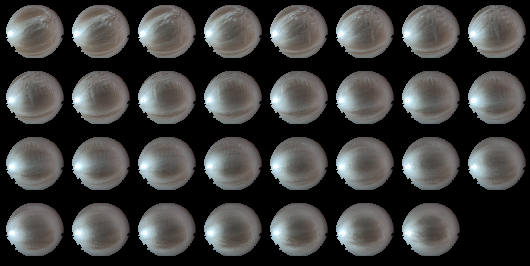

In [14]:
# Fixed input for debugging
fixed_x = next(iter(train_loader))
print(fixed_x[0].shape) # 0 because VideoDataset has batch_size videos, not images.
print(f"Number of images per video: {fixed_x[0].shape[0]}")
print(f"Number of images per batch: {fixed_x[0].shape[0]*bs}")
torchvision.utils.save_image(fixed_x[0], 'save/real_image.png')
idisplay.Image('save/real_image.png')

In [ ]:
#cnn = torch.nn.Conv2d()
#rnn = torch.nn.LSTM()

In [15]:
image_channels = fixed_x[0].size(1)

In [16]:
z_dim = 64

In [17]:
#vae = VAE(image_channels=image_channels).to(device)
vae = VAE(image_channels=image_channels, z_dim=z_dim, device=device).to(device)
last_epoch = 0
if os.path.exists(output_path):
    vae.load_state_dict(torch.load(output_path, map_location='cpu'))
    last_epoch = 19
else:
    print('No states loaded')

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(vae))

4448323


In [19]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [20]:
epochs = 50

In [ ]:
for epoch in range(last_epoch, epochs):
    vae.train()
    for idx, videos in enumerate(train_loader):
        images = torch.stack([img[randint(0, len(img)-1)] for img in videos])
        # Only taking one frame per video into account, all images of same videos are very similar
        #images = videos.flatten(0,1)
        recon_images, mu, logvar = vae(images)
        loss, bce, kld = vae_loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx % 10 == 0:
            to_print = (
                f"Epoch[{epoch+1}/{epochs}] B[{idx+1}/{len(train_loader)}] Loss: {loss.data.item()/bs:.4g} "
                f"{bce.data.item()/bs:.4g} {kld.data.item()/bs:.3g}"
            )
            print(to_print)
    torch.save(vae.state_dict(), output_path)


In [21]:
def compare(x):
    recon_x, _, _ = vae(x)
    return torch.cat([x, recon_x])

In [22]:
def show(data):
    torchvision.utils.save_image(data, 'save/sample_image.png')
    display(idisplay.Image('save/sample_image.png', width=700, unconfined=True))

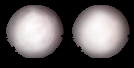

In [23]:
vae.eval()
fixed_x = train_dataset[randint(1, 5000)][0].unsqueeze(0)
compare_x = compare(fixed_x)

show(compare_x.data.cpu())

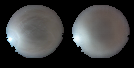

In [24]:
vae.eval()
fixed_x = test_dataset[randint(0, 4466)][0].unsqueeze(0)
compare_x = compare(fixed_x)

show(compare_x.data.cpu())

## LSTM

In [25]:
model_name = 'CNNLSTM'
output_path = os.path.join(cwd,"save", f"{model_name}.torch")

cnnvae = vae
cnnvae.eval()
lstm = CNNLSTM(cnnvae, z_dim, 256, 1, device=device)


last_epoch = 0
if os.path.exists(output_path):
    lstm.load_state_dict(torch.load(output_path, map_location='cpu'))
    last_epoch = 1
else:
    print('No states loaded')

for param in lstm.cnnvae.parameters():
    param.requires_grad = False

In [26]:
bs = 64
# Recreate Dataset and DataLoader, now without stacking
train_dataset = common.VideoDataset(dss['trainval']['images_log'], dss['trainval']['images_pred'], transform=transform, stack_videos=False, device=device)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

test_dataset = common.VideoDataset(dss['test']['images_log'], dss['test']['images_pred'], transform=transform, stack_videos=False, device=device)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

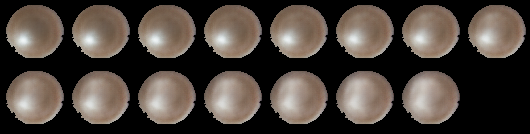

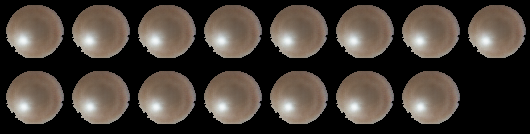

In [27]:
with torch.no_grad():
    input_video, target_video = train_dataset[randint(1, 5000)]
    target_fuzzy, _, _ = lstm.cnnvae(target_video)
    pred = lstm(input_video.unsqueeze(0), 15).squeeze(0)
    show(pred.data.cpu())
    show(target_fuzzy.data.cpu())

In [ ]:
loss_function = nn.MSELoss()
loss_function = lambda o,t: F.binary_cross_entropy(o,t, reduction='sum')#NLLLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=0.1)
epochs = 30

# Scheduled sampling parameters
initial_teacher_forcing_ratio = 1.0
final_teacher_forcing_ratio = 0.1
scheduled_sampling_decay = 0.3  # decay rate per epoch

lstm.train()
lstm.cnnvae.eval()

for epoch in range(last_epoch, epochs):
    teacher_forcing_ratio = final_teacher_forcing_ratio + (initial_teacher_forcing_ratio - final_teacher_forcing_ratio) * math.exp(-scheduled_sampling_decay * epoch)
    print(f"Epoch[{epoch+1}/{epochs}] teacher_forcing_ratio: {teacher_forcing_ratio}")
    for idx, (videos, targets) in enumerate(train_loader):
        #lstm.lstm.zero_grad()
        seq_dims = targets.shape[0:2]
        targets = targets.flatten(0,1)
        targets, _, _ = lstm.cnnvae(targets)
        targets = torch.unflatten(targets, 0, seq_dims)
        outputs = lstm(videos, targets.size(1), targets, teacher_forcing_ratio)
        loss = loss_function(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx % 10 == 0:
            to_print = (
                f"Epoch[{epoch+1}/{epochs}] B[{idx+1}/{len(train_loader)}]"
                f" Loss: {loss.data.item()/bs:.4g} "
            )
            print(to_print)
    torch.save(lstm.state_dict(), output_path)

Epoch[2/30] teacher_forcing_ratio: 0.766736398613546
Epoch[2/30] B[1/834] Loss: 6.767e+04 
Epoch[2/30] B[11/834] Loss: 6.745e+04 
Epoch[2/30] B[21/834] Loss: 6.647e+04 
Epoch[2/30] B[31/834] Loss: 6.725e+04 
Epoch[2/30] B[41/834] Loss: 6.684e+04 


In [ ]:
with torch.no_grad():
    input_video, target_video = train_dataset[randint(1, 5000)]
    target_fuzzy, _, _ = lstm.cnnvae(target_video)
    pred = lstm(input_video.unsqueeze(0), 15).squeeze(0)
    show(pred.data.cpu())
    show(target_fuzzy.data.cpu())

In [ ]:
# Predict with always given the true target value for previous calcs
with torch.no_grad():
    input_video, target_video = train_dataset[randint(1, 5000)]
    target_fuzzy, _, _ = lstm.cnnvae(target_video)
    pred = lstm(input_video.unsqueeze(0), 15, target_fuzzy.unsqueeze(0), 1).squeeze(0)
    show(pred.data.cpu())
    show(target_fuzzy.data.cpu())